# Free Energy Calculations
In this Notebook, we want to give a short glimpse on Free Energy Calculations with Ensembler. 

Free energies are an very important topic in computational chemistry. As they are fundamental to thermodynamics and can give a lot of information for different changes to a system. Generally we can destinguish three types of free energies: thermodynamic, conformational and alchemical. 
The thermodynamic category is a free energy difference related to a change of an thermodynamic property of the system. The conformational free energy difference can be used to describe a conformational change of a molecule (phase space areas) and the alchemical free energy is describing a change in the chemical space of the molecule (e.g.: methylation).

To calculate a free energy can be very tricky. A challenge might be sampling convergence due to high energy barriers or entropy differences. 

To be able to estimate the influence of a chemical change, one needs to calculate the free energies of both so called states.




Here we calculate the Free Energy as:

$F_i = V_i - T_i  S_i = -\beta ln(Z_i) $



Or we can use the statistical approach:

$F_i(t) = -\frac{1}{\beta}  ln(\langle e^{-\beta H_i(t)}\rangle_i)$

With the Gibbs Free Energy of state i and state J we can get the Free Energy Difference of the change.

$\Delta F_{ij} = F_j - F_i = -\beta ln(\frac{Z_i}{Z_j})$ 

This allows us to estimate the influence of the change.

A free energy Calculation can be described contains three parts:
* The System: Normally these contian multiple states.
* The Sampling Method: The way how the Free Energy landscape will be integrated.
* The Free Energy Estimator: The way, the free energy will be derived from the simulation.


In this notebook we will cover following methods:
* Free Energy Pertubation
  * Zwanzig
  * BAR
* linear coupling
    * FEP with 10 $\lambda$-points
    * TI with 10 $\lambda$-points
* exponential coupling
    * EDS
* hybrid coupling
    * $\lambda$-EDS
* Enhanced Sampling methods:
    * Conveyor Belt
    * RE-EDS


References:
    - a good page to learn about free energies: http://www.alchemistry.org 

In [1]:
#Here some imports:

##System Path
import os, sys
path = os.getcwd()+"/.."
sys.path.append(path)

##basics
import numpy as np
from matplotlib import pyplot as plt

##Ensembler
from ensembler.analysis.freeEnergyCalculation import zwanzigEquation, threeStateZwanzigReweighting, bennetAcceptanceRatio

from ensembler.potentials import OneD as pot
from ensembler.samplers.stochastic import metropolisMonteCarloIntegrator, langevinIntegrator
from ensembler.system.basic_system import system
from ensembler.system.perturbed_system import perturbedSystem
from ensembler.system.eds_system import edsSystem

from ensembler.visualisation.plotSimulations import oneD_simulation_analysis_plot

import matplotlib
from ensembler.visualisation import style
from ensembler.visualisation import plot_layout_settings
for key, value in plot_layout_settings.items():
    matplotlib.rcParams[key] = value


## Benchmarking parameters
Here we define some parameters that allow us an easier comparison of the different methods.

In [2]:
simulation_steps_total_per_approach = 10000 #more steps better free energies, but if you just want to try 1000 ist quite fast.
space_range = [-5, 5]
temperature = 30 # for the metropolis criterion of MMC sampler
sampler = metropolisMonteCarloIntegrator(step_size_coefficient=1)


## Setting up a System
We are now going to Setup a system, for the Free Energy Calculations. For this Notebook, we want to keep it simple. Therefore two 1D-Harmonic Oscillators with different shifted minima and force constants shall be perfect for us. These two harmonic oscillators could for example describe the difference of types of bonds.


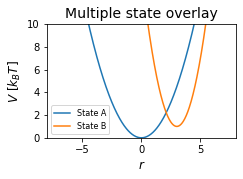

In [3]:
#Build System
#System Parameters:
yoff1 = 0
xoff1 = 0
force_constant = k1 = 1

entropic_difference = k2 = 3
potential_difference = yoff2 = 1
phase_space_distance = xoff2 = 3

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

#Visualize
from ensembler.visualisation.plotPotentials import multiState_overlays

fig, _ = multiState_overlays([h1,h2])
fig.savefig("2state_systems.pdf")


## Analyctical Solution
The Analytical solution for our problem can be calculated as follows: 


Check Eq

Gibbs Energy:   
$ F_i = V_i - T_i  S_i $

For a harmonic Oscillator the entropy term can be formulated as:

$F_i = V_i - \frac{1}{\beta} log(\sqrt{\frac{2 \pi}{k_i \beta}})$



The final free energy difference is:

$\Delta F_{ij} = F_j - F_i$ 


In [60]:
#Analytical Solution
beta = 1 # beta is in kT

F_1 = yoff1 -(1/(2*beta)) * np.log(np.sqrt((2*np.pi)/(k1*beta)))
F_2 = yoff2 -(1/(2*beta)) * np.log(np.sqrt((2*np.pi)/(k2*beta)))
dF_expected = F_2-F_1

print("expected dG: ", dF_expected)


expected dG:  1.2746530721670273


## Free Energy Pertubation Method with BAR/Zwanzig
In this Category of methods, each of the endstates will be simulated seperatley. Afterwards, the trajectories will be evaluated  with the opposite state and afterwards the free energy will be evaluated.


### Sampling
Now we build first the two systems and run the simulations.

Simulation:  Simulation: 100%|██████████| 10000/10000 [00:01<00:00, 6797.88it/s]


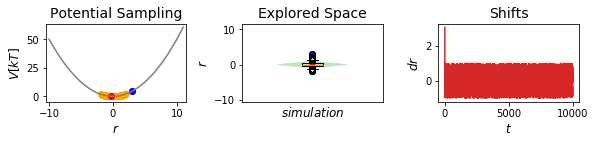

In [5]:
#Simulate the two states:
steps = simulation_steps_total_per_approach
equilibration_steps = 100

##Build Systems
system1 = system(potential=h1, sampler=sampler, temperature=temperature)
system2 = system(potential=h2, sampler=sampler, temperature=temperature)

##Simulate:
system1.simulate(steps)
state1_traj = system1.trajectory
_ = oneD_simulation_analysis_plot(system1, limits_coordinate_space=np.linspace(-10,10) )

### Analysis
#### Zwanzig Equation

$        dF_{ij_{Zwanzig}}(V_i, V_j) = - \beta \ln(\langle e^{-\beta(V_j-V_i)} \rangle_i ) $

In [6]:
V1=state1_traj.total_potential_energy[equilibration_steps:]
V2=h2.ene(state1_traj.position[equilibration_steps:])

zwanz = zwanzigEquation(kT=True)
dF_zwanzig = zwanz.calculate(Vi=V1, Vj=V2)

print("Expected Result: ", dF_expected)
print("Zwanzig Result: ", dF_zwanzig)
print()
print("Difference:", dF_zwanzig - dF_expected)


Expected Result:  1.2746530721670273
Zwanzig Result:  8.38721779130273

Difference: 7.112564719135703


#### Bennet Acceptance Ratio (BAR)

Equation:
$ ddF_{ij_{BAR}}(V_i, V_j) = \ln(\frac{\langle f(V_i-Vj+C) \rangle_j}{\langle f(V_j-V_i-C) \rangle_i}) + C - ln(\frac{n_1}{n_0})$

with f as fermi function: 
- $ f(x) = \frac{1}{1+e^{-\beta x}}$

$dF_{ij_{BAR}}$ is calculated iterativley with $ddF_{ij_{BAR}}(V_i, V_j)$, till convergence

Simulation:  Simulation: 100%|██████████| 10000/10000 [00:01<00:00, 5568.57it/s]


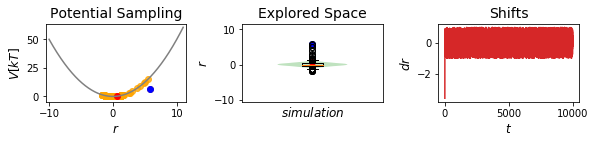

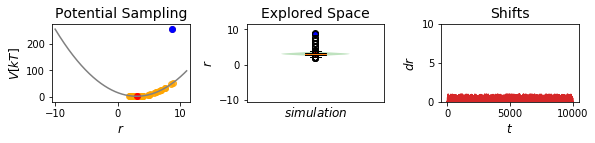

In [7]:
#Simulate the two states:
steps = simulation_steps_total_per_approach
equilibration_steps = 100

##Build Systems

system1 = system(potential=h1, sampler=sampler, temperature=temperature)
system2 = system(potential=h2, sampler=sampler, temperature=temperature)

##Simulate:
system1.simulate(steps, withdraw_traj=True, init_system=True)
state1_traj = system1.trajectory
_ = oneD_simulation_analysis_plot(system1, limits_coordinate_space=np.linspace(-10,10))

system2.simulate(steps, withdraw_traj=True, init_system=True)
state2_traj = system2.trajectory

#visualize
_ = oneD_simulation_analysis_plot(system2, limits_coordinate_space=np.linspace(-10,10))
plt.ylim([0,10])
pass

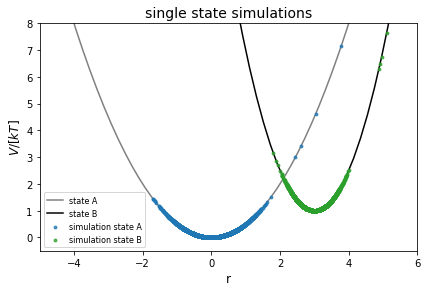

In [8]:
from ensembler import visualisation
    
positions = np.linspace(-10,10, 100)
fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
traj_pos = list(system1.trajectory.position)
ax[0].plot(positions, system1.potential.ene(positions), c="grey", label="state A", zorder=-10)
ene = system1.potential.ene(traj_pos)
ax[0].scatter(traj_pos, ene, c="C0",alpha=0.8, label="simulation state A",s=8)
ax[0].set_ylim([0,8])

positions = np.linspace(-10,10, 100)
traj_pos = list(system2.trajectory.position)
ax[0].plot(positions, system2.potential.ene(positions), c="black", label="state B", zorder=-10)
ene = system2.potential.ene(traj_pos)
ax[0].scatter(traj_pos, ene, c="C2",alpha=0.8, label="simulation state B",s=8)

ax[0].set_ylim([-0.5,8])
ax[0].set_xlim([-5,6])
ax[0].set_xlabel("r")
ax[0].set_ylabel("$V/[kT]$")
ax[0].legend()
ax[0].set_title("single state simulations")
#ax[0].set_title("State 2")
fig.savefig("freeEnergyPertubation.pdf")

In [9]:
#Sampling l1
V11=h1.ene(state1_traj.position)
V21=h2.ene(state1_traj.position)

#Sampling l2
V12=h1.ene(state2_traj.position)
V22=h2.ene(state2_traj.position)

bar = bennetAcceptanceRatio(kT=True, convergence_radius=0.01, max_iterations=1000)
dF_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22, verbose=False)

print()
print("Expected Result: ", dF_expected)
print("BAR Result: ", dF_bar)
print()
print("Difference:", dF_bar - dF_expected)



Final Iterations:  9  Result:  2.8326036752713817

Expected Result:  1.2746530721670273
BAR Result:  2.8326036752713817

Difference: 1.5579506031043544


## Coupling Methods

If the phase space overlap of the two state is low, the free energy estimate might deviate a lot from the real result be very bad.
This issue can be solved by coupling the phase space of the two states in a simulation.
Two ways of coupling will be discussed. 
The first one is $\lambda$-coupling which forms a linear combination of the two states, this is used for FEP and TI.
Second there is the exponential boltzmann coupling used in enveloping distribution sampling (EDS). 

### $\lambda$ - Coupling 



### Sampling

Text(0.5, 1.0, 'Sampled Potentials')

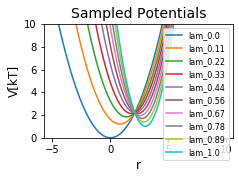

In [10]:
#Build Potential
V_perturbed = pot.linearCoupledPotentials(Va=h1, Vb=h2)

#Visualize
lambda_points = 10
positions = np.arange(-5,10, 0.2)
lambda_windows=np.linspace(0,1, lambda_points)
for lam in lambda_windows:
    V_perturbed.set_lambda(lam)
    ene =  V_perturbed.ene(positions)
    plt.plot(positions,ene, label="lam_"+str(round(lam, 2)))
    
plt.legend()

plt.ylim([0,10])
plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

In [11]:
steps = int(simulation_steps_total_per_approach)#//(lambda_points)
equilibration_steps = 30
print(steps)
perturbed_system = perturbedSystem(potential=V_perturbed, sampler=sampler, temperature=temperature)

system_trajs = {}
for lam in lambda_windows:
    perturbed_system.set_lambda(lam)
    perturbed_system.simulate(steps, withdraw_traj=True, init_system=True)
    system_trajs.update({lam: perturbed_system.trajectory})


Simulation:  Simulation:   0%|          | 0/10000 [00:00<?, ?it/s]

10000


Simulation:  Simulation: 100%|██████████| 10000/10000 [00:01<00:00, 5278.94it/s]


### Analysis

#### Exponential Formula

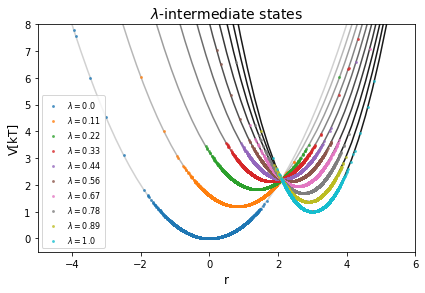

In [12]:
from ensembler import visualisation
from matplotlib import cm
#Visualize
positions = np.linspace(-10, 10, 100)
y_range = [-0.5, 8]


fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
axes = list([axes])
enes = []
all_lams = sorted(list(system_trajs.keys()))

for lamI in all_lams:
    trajI = system_trajs[lamI]
    V_perturbed.set_lambda(lamI)
    ene =  V_perturbed.ene(positions)
    enes.append(ene)
    if(lamI==1): 
        c="black"
    else:
        c = cm.get_cmap("binary")(lamI+0.2)
    
    axes[0].plot(positions,ene, c=c, zorder=-10,alpha=0.9)
    axes[0].scatter(trajI.position, V_perturbed.ene(trajI.position),s=8,alpha=0.8, linewidths=0, 
                    label="$\lambda=$"+str(round(lamI, 2)),)#c="orange")
    
logExp=list(map(lambda x: np.log(np.exp(x)), enes))

axes[0].legend()
axes[0].set_ylim(y_range)

axes[0].set_ylabel("V[kT]")
axes[0].set_xlabel("r")
axes[0].set_title("$\lambda$-intermediate states")

axes[0].set_xlim([-5,6])


fig.savefig("linear_coupled.pdf")

### FEP with multiple lambda windows:

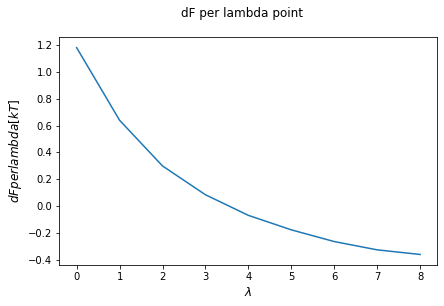


Expected Result:  1.2746530721670273
Sum of intermediates Result:  1.0004315367448022

Difference: -0.27422153542222505


In [13]:
dA_i_fw = []
zwanz = zwanzigEquation()
all_lams = list(sorted(list(system_trajs.keys())))
for lamI, lamJ in zip(all_lams, all_lams[1:]):
    trajI = system_trajs[lamI]
    trajJ = system_trajs[lamJ]

    Vi_fw = trajI.total_potential_energy
    Vj_fw = trajJ.total_potential_energy

    
    dF_zwanzig_fw = zwanz.calculate(Vi=Vi_fw, Vj=Vj_fw)
    
    dA_i_fw.append(dF_zwanzig_fw)

fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
axes.plot(dA_i_fw)
axes.set_ylabel("$dFper lambda [kT]$")
axes.set_xlabel("$\lambda$")

fig.suptitle("dF per lambda point")

plt.show()

dF_FEP_10lambda = np.sum(dA_i_fw)

print()
print("Expected Result: ", dF_expected)
print("Sum of intermediates Result: ", dF_FEP_10lambda)
print()
print("Difference:", dF_FEP_10lambda - dF_expected)


#### Thermodynamic Integration

Text(0.5, 0.98, 'dH/d$\\lambda$ for each Lambda point')

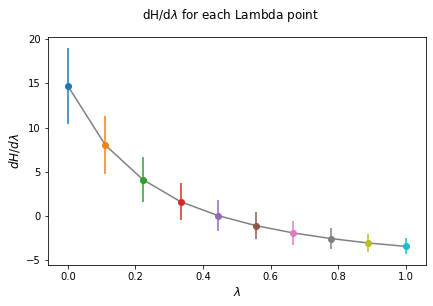

In [14]:
fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)

lam_stats = {}
for lam in system_trajs:
    lam_mean, lam_std = np.mean(system_trajs[lam].dhdlam[equilibration_steps:]), np.std(system_trajs[lam].dhdlam[equilibration_steps:])
    lam_stats.update({lam:{"mean":lam_mean, "std": lam_std}})
    
    axes.scatter(lam, lam_mean)
    axes.errorbar(lam, lam_mean, lam_std)

axes.plot(sorted(lam_stats), [lam_stats[x]["mean"] for x in sorted(lam_stats)], color="grey", zorder=-1)
axes.set_ylabel("$dH/d\lambda$")
axes.set_xlabel("$\lambda$")

fig.suptitle("dH/d$\lambda$ for each Lambda point")


In [15]:
from scipy import integrate

lam = list(sorted(lam_stats.keys()))
means = [lam_stats[x]['mean'] for x in lam] 
stds = [lam_stats[x]['std'] for x in lam] 

dF_trapez = integrate.trapz(x=lam, y=means)
dF_err = integrate.trapz(x=lam, y=stds)

print()
print("Expected Result: ", dF_expected)
print("trapez Rule Result: ", dF_trapez, "+-", dF_err)
print()
print("Difference:", dF_trapez - dF_expected)



Expected Result:  1.2746530721670273
trapez Rule Result:  1.2132688196959016 +- 1.9096456276443603

Difference: -0.061384252471125667


## Exponentially Coupled - Enveloping Distribution Sampling (EDS) - BAR/RewightedFEP

Text(0.5, 1.0, 'Sampled Potentials')

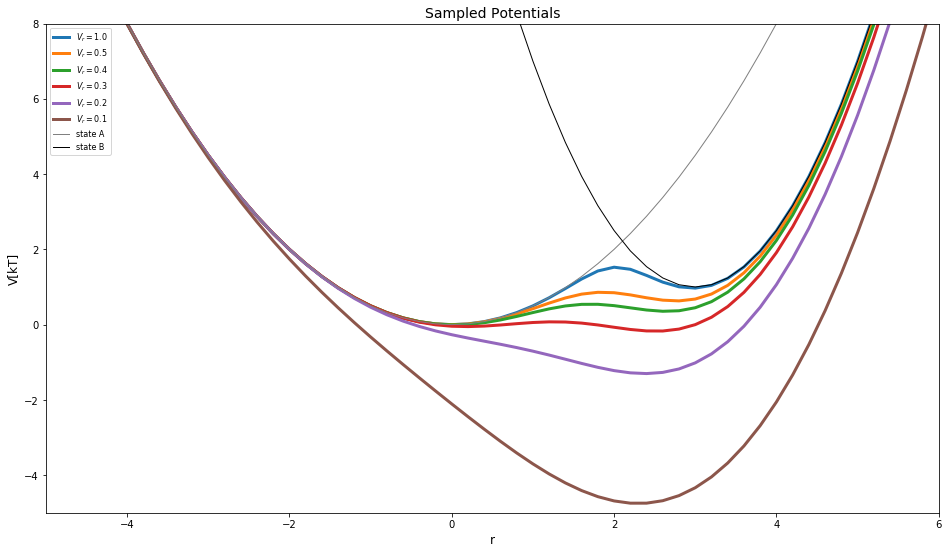

In [17]:
#Build Potential
s=1
Eoff = [0, 0]
V_eds = pot.envelopedPotential(V_is=[h1,h2] , s=s, eoff=Eoff)
s_values = np.array([ 1,0.5, 0.4, 0.3, 0.2, 0.1])

#Visualize
positions = np.arange(-10,15, 0.2)
fig = plt.figure(figsize=[16,9])

for s in s_values:
    V_eds.s=s
    plt.plot(positions,V_eds.ene(positions), lw=3, label="$V_r="+str(round(s,3))+"$")

plt.plot(positions,h1.ene(positions), label="state A", lw=1, color="grey")
plt.plot(positions,h2.ene(positions), label="state B", lw=1, color="black")

V_eds.s=0.3
plt.legend()  
plt.ylim([-5,8])
plt.xlim([-5,6])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

In [18]:
steps = simulation_steps_total_per_approach
equilibration_steps = 100

good_s_value=0.3
eds_system = edsSystem(potential=V_eds, sampler=sampler, eds_s=good_s_value, eds_Eoff=Eoff, temperature=temperature)

eds_system.simulate(steps, withdraw_traj=True, init_system=True)
eds_traj = eds_system.trajectory

Simulation:  Simulation: 100%|██████████| 10000/10000 [00:07<00:00, 1397.33it/s]


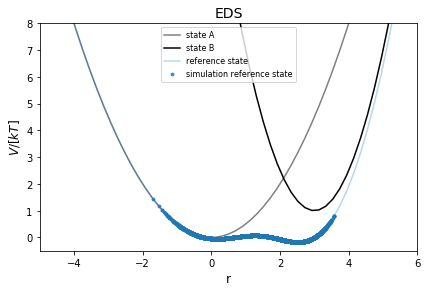

In [19]:
from ensembler import visualisation
    
traj = eds_traj.iloc[equilibration_steps:]
positions = np.linspace(-10,10, 100)
h1_ene = h1.ene(positions)
h2_ene = h2.ene(positions)
V_eds.s = traj.s[equilibration_steps]
eds_ene = V_eds.ene(positions)

traj_pos = list(traj.position)
traj_ene = list(traj.total_potential_energy)

fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
ax[0].plot(positions, h1_ene, c="grey", label="state A", zorder=-10,)
ax[0].plot(positions, h2_ene, c="black", label="state B", zorder=-10)
ax[0].plot(positions, eds_ene, c="C0", label="reference state", zorder=-10,alpha=0.3)

ax[0].scatter(traj_pos, traj_ene, c="C0",alpha=0.8, label="simulation reference state",s=8)

ax[0].set_ylim([-0.5,8])
ax[0].set_xlim([-5,6])
ax[0].set_xlabel("r")
ax[0].set_ylabel("$V/[kT]$")

ax[0].legend()
ax[0].set_title("EDS")

fig.savefig("EDS_sampling.pdf")

### FEP-EDS_Evaluation

In [20]:
rew_zwanz = threeStateZwanzigReweighting(kT=True)

traj_positions = eds_traj.position[equilibration_steps:]
Vrr = eds_traj.total_potential_energy[equilibration_steps:]
V1r = h1.ene(traj_positions)
V2r = h2.ene(traj_positions)

dF_EDS = rew_zwanz.calculate(Vi=V1r, Vj=V2r, Vr=Vrr)

print("dF ", dF_EDS)
print("deviation: ", dF_EDS-dF_expected)


dF  1.5444115059351624
deviation:  0.26975843376813513


### BAR-EDS_Evaluation

In [21]:

traj_positions = eds_traj.position[equilibration_steps:]

#Sampling l1
V11=h1.ene(state1_traj.position)
V21=h2.ene(state1_traj.position)
Vr1 = V_eds.ene(list(state1_traj.position))

#Sampling l2
V12=h1.ene(state2_traj.position)
V22=h2.ene(state2_traj.position)
Vr2 = V_eds.ene(list(state2_traj.position))

Vrr = eds_traj.total_potential_energy[equilibration_steps:]
V1r = h1.ene(traj_positions)
V2r = h2.ene(traj_positions)

bar = bennetAcceptanceRatio(kT=True)
setattr(bar, "verbose", False)
df_BAR_1R = bar.calculate(Vj_i=V1r, Vi_i=Vrr, Vi_j=Vr1, Vj_j=V11,)
dF_EDS = rew_zwanz.calculate(Vi=V1r, Vj=V2r, Vr=Vrr)
df_BAR_2R = bar.calculate(Vj_i=V2r, Vi_i=Vrr, Vi_j=Vr2, Vj_j=V22)

dF_EDS_bar = df_BAR_1R-dF_EDS+df_BAR_2R

print("2R", df_BAR_2R, "rr", dF_EDS, "1R", df_BAR_1R)
print("dF_BAR:  ", dF_EDS_bar)
print("deviation: ", dF_EDS_bar-dF_expected)






Final Iterations:  5  Result:  0.6683140734869367

Final Iterations:  7  Result:  2.057860420185253
2R 2.057860420185253 rr 1.5444115059351624 1R 0.6683140734869367
dF_BAR:   1.1817629877370273
deviation:  -0.09289008443000002


## Hybrid Methods - $\lambda$-EDS

0 	 100.0
1 	 1.0
2 	 0.5
3 	 0.3
4 	 0.2
5 	 0.1


Text(0.5, 1.0, 'Sampled Potentials')

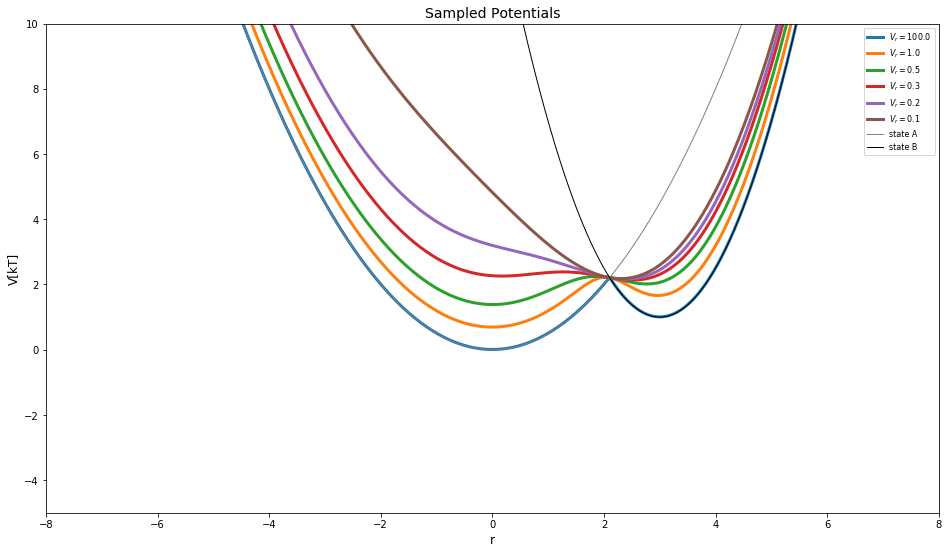

In [22]:
#Build Potential
s=1
Eoff = [0,0]
V_hleds = pot.lambdaEDSPotential(V_is=[h1,h2] , s=s, lam=0.5)
s_values = np.array([100, 1, 0.5, 0.3, 0.2, 0.1])

#Visualize
positions = np.linspace(-10,10, 1000)
fig = plt.figure(figsize=[16,9])

for ind,s in enumerate(s_values):
    print(ind, "\t", s)
    V_hleds.s=s
    plt.plot(positions,V_hleds.ene(positions), lw=3, label="$V_r="+str(round(s,3))+"$")

plt.plot(positions,h1.ene(positions), label="state A", lw=1, color="grey")
plt.plot(positions,h2.ene(positions), label="state B", lw=1, color="black")


plt.legend()  
plt.ylim([-5,10])
plt.xlim([-8,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")


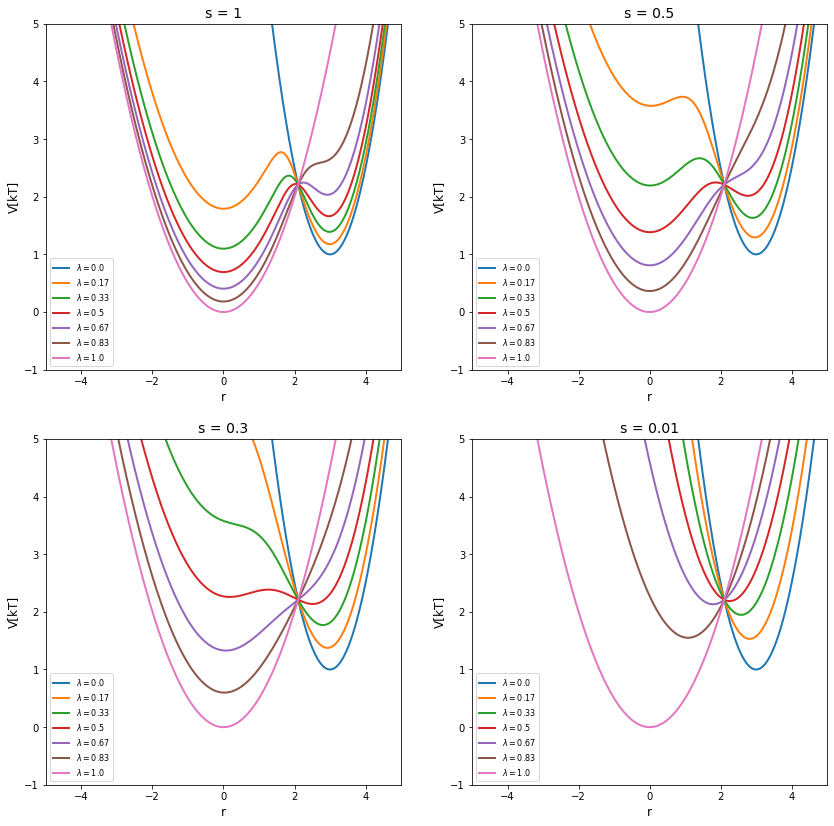

In [23]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[14,14])
axes = np.concatenate(axes)
s_values = [1, 0.5,  0.3, 0.01]
lams=list(sorted(list(np.linspace(start=0, stop=1, num=7))))


for ax, s in zip(axes, s_values):
    V_hleds.s= s
    for ind,lam in enumerate(lams):
        V_hleds.lam=lam
        ax.plot(positions,V_hleds.ene(positions), lw=2, label="$\lambda="+str(round(lam,2))+"$")

    #ax.plot(positions,h1.ene(positions), label="state A", lw=1, color="grey", zorder=10)
    #ax.plot(positions,h2.ene(positions), label="state B", lw=1, color="black", zorder=10)

    ax.legend()  
    ax.set_ylim([-1,5])
    ax.set_xlim([-5,5])

    ax.set_ylabel("V[kT]")
    ax.set_xlabel("r")
    ax.set_title("s = "+str(s))

In [24]:
#simulate
steps = simulation_steps_total_per_approach
equilibration_steps = 100

hleds_system = edsSystem(potential=V_hleds, sampler=sampler, eds_Eoff=Eoff, temperature=temperature)

hleds_simulation_trajs = []
good_s_value = 0.3
hleds_system.set_s(good_s_value)
hleds_system.potential.lam = 0.5
hleds_system.simulate(steps, withdraw_traj=True, init_system=True)
hleds_simulation_traj = hleds_system.trajectory


Simulation:  Simulation: 100%|██████████| 10000/10000 [00:07<00:00, 1296.50it/s]


In [25]:

hleds_system.potential.lam = 0.25
hleds_system.simulate(steps, withdraw_traj=True, init_system=True)
hleds_simulation_traj2 = hleds_system.trajectory


hleds_system.potential.lam = 0.75
hleds_system.simulate(steps, withdraw_traj=True, init_system=True)
hleds_simulation_traj3 = hleds_system.trajectory

Simulation:  Simulation: 100%|██████████| 10000/10000 [00:05<00:00, 1775.55it/s]


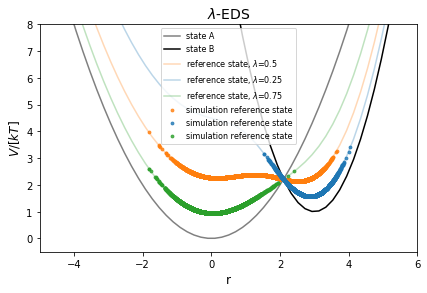

In [26]:
from ensembler import visualisation
    
traj = hleds_simulation_traj.iloc[equilibration_steps:]
traj2 = hleds_simulation_traj2.iloc[equilibration_steps:]
traj3 = hleds_simulation_traj3.iloc[equilibration_steps:]

positions = np.linspace(-10,10, 100)
h1_ene = h1.ene(positions)
h2_ene = h2.ene(positions)
V_hleds.s = traj.s[equilibration_steps]

V_hleds.lam = 0.5
eds_ene = V_hleds.ene(positions)
V_hleds.lam = 0.25
eds_ene1 = V_hleds.ene(positions)
V_hleds.lam = 0.75
eds_ene2 = V_hleds.ene(positions)

traj_pos = list(traj.position)
traj_ene = list(traj.total_potential_energy)
traj_pos2 = list(traj2.position)
traj_ene2 = list(traj2.total_potential_energy)
traj_pos3 = list(traj3.position)
traj_ene3 = list(traj3.total_potential_energy)

fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
ax[0].plot(positions, h1_ene, c="grey", label="state A", zorder=-10,)
ax[0].plot(positions, h2_ene, c="black", label="state B", zorder=-10)
ax[0].plot(positions, eds_ene, c="C1", label="reference state, $\lambda$=0.5", zorder=-10,alpha=0.3)
ax[0].plot(positions, eds_ene1, c="C0", label="reference state, $\lambda$=0.25", zorder=-10,alpha=0.3)
ax[0].plot(positions, eds_ene2, c="C2", label="reference state, $\lambda$=0.75", zorder=-10,alpha=0.3)

ax[0].scatter(traj_pos, traj_ene, c="C1",alpha=0.8, label="simulation reference state",s=8)
ax[0].scatter(traj_pos2, traj_ene2, c="C0",alpha=0.8, label="simulation reference state",s=8)
ax[0].scatter(traj_pos3, traj_ene3, c="C2",alpha=0.8, label="simulation reference state",s=8)

ax[0].set_ylim([-0.5,8])
ax[0].set_xlim([-5,6])
ax[0].set_xlabel("r")
ax[0].set_ylabel("$V/[kT]$")
    
ax[0].legend()
ax[0].set_title("$\lambda$-EDS")

fig.savefig("hlEDS_sampling.pdf")

In [27]:
rew_zwanz = threeStateZwanzigReweighting(kT=True)
zwanz = zwanzigEquation(kT=True)

traj_positions = hleds_simulation_traj.position[equilibration_steps:]
Vr = hleds_simulation_traj.total_potential_energy[equilibration_steps:]
V1 = h1.ene(traj_positions)
V2 = h2.ene(traj_positions)

dF_leds = rew_zwanz.calculate(Vi=V1, Vj=V2, Vr=Vr)

print("dF ", dF_leds)
print("deviation: ", dF_leds-dF_expected)
    


dF  1.600083538160825
deviation:  0.32543046599379766


## Enhanced Sampling with system Coupling

### Conveyor Belt TI

In [28]:
import ensembler.ensemble.replicas_dynamic_parameters as cvb
from ensembler.system import perturbed_system

#CHEKC HERE H1 and H2 die
equilibration_steps = 100
numsys = 4
V_perturbed = pot.linearCoupledPotentials(Va=h1, Vb=h2)

lam_system = perturbed_system.perturbedSystem(potential=V_perturbed , sampler=sampler, temperature=temperature)
conveyorBelt=cvb.conveyorBelt(0.0, numsys, system=lam_system, build=False)


In [29]:
conveyorBelt.simulate(simulation_steps_total_per_approach)
cvb_trajs = conveyorBelt.get_trajectories()


In [30]:
cvb_trajs

{0:                    position  temperature  total_system_energy  \
 0                 -0.776868         30.0            11.349429   
 1      -0.15883811640181045         30.0             0.012615   
 2       0.09695904504991193         30.0             0.004701   
 3         1.066069109967636         30.0             2.038650   
 4        1.1476747207332743         30.0             1.994201   
 ...                     ...          ...                  ...   
 19996    1.2628670882974202         30.0             0.828345   
 19997    0.7393252277827925         30.0             1.850221   
 19998    1.4908554430783583         30.0             1.732300   
 19999    1.5278681105601164         30.0             1.746570   
 20000    1.3356428955795967         30.0             1.692986   
 
        total_potential_energy  total_kinetic_energy                dhdpos  \
 0                   11.349429                   NaN              -6.05374   
 1                    0.012615                 

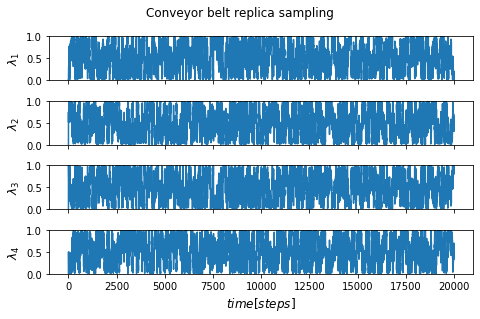

In [31]:
fig, axes = plt.subplots(nrows=4, figsize=style.figsize_doubleColumn, sharex=True)
keys=list(sorted(list(cvb_trajs.keys())))
for key in keys:
    axes[key].plot(cvb_trajs[key].lam)
    axes[key].set_ylabel("$\lambda_"+str(key+1)+"$")
    if(key == keys[-1]):    axes[key].set_xlabel("$time [steps]$")
    axes[key].set_ylim([0,1])
fig.suptitle("Conveyor belt replica sampling", y=1.05)
fig.tight_layout()

<BarContainer object of 50 artists>

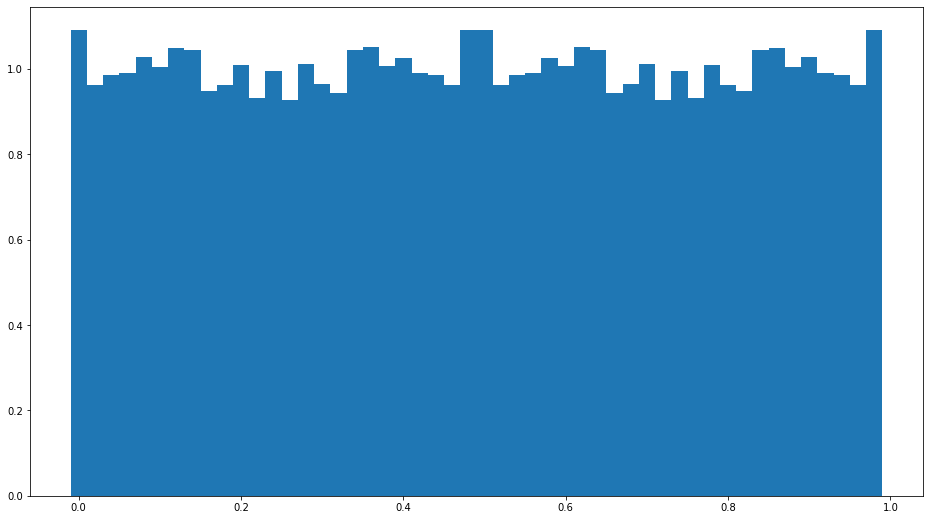

In [32]:
import pandas as pd
nbins=50
mega_traj = pd.concat(list(map(lambda x: x[equilibration_steps:], cvb_trajs.values())), ignore_index=True)

frequencies, lam_bins = np.histogram(list(sorted(np.unique(mega_traj.lam))), bins=nbins, density=True)
plt.figure(figsize=[16,9])
plt.bar(x=lam_bins[:-1], height=frequencies, width=1/nbins)

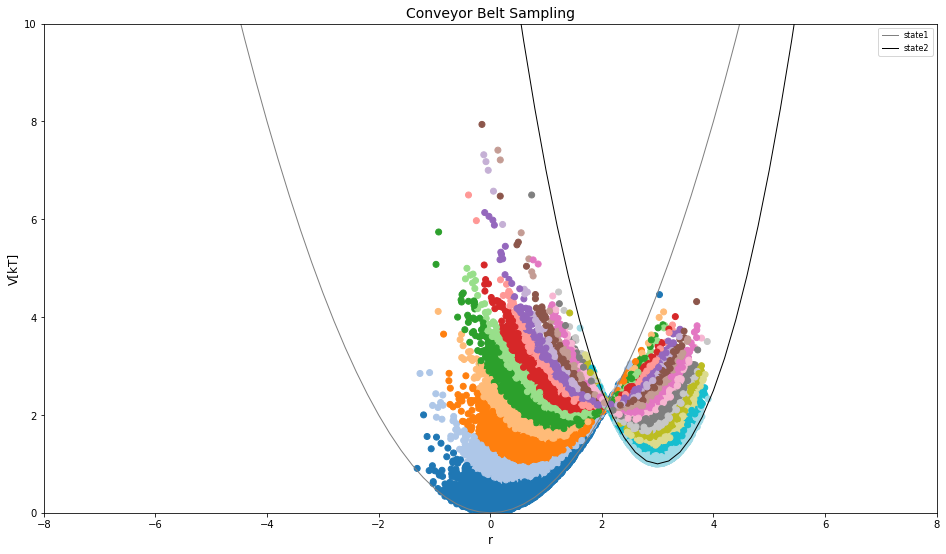

In [33]:
import pandas as pd
mega_traj = pd.concat(list(cvb_trajs.values()), ignore_index=True)

def find_nearest_bin(array,value):
    cbins =[]
    for val in value:
        idx = np.argmin(np.abs(array-val))
        cbins.append(idx)
    return cbins

discrete_traj = np.array(find_nearest_bin(value=mega_traj.lam[equilibration_steps:], array=lam_bins))

fig, axes = plt.subplots(ncols=1, figsize=[16,9])
axes = [axes]
axes[0].scatter(list(mega_traj.position[equilibration_steps:]), mega_traj.total_potential_energy[equilibration_steps:], c=discrete_traj, cmap="tab20")

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)
positions = np.arange(-10,10, 0.2)
axes[0].plot(positions, h1.ene(positions), label="state1", lw=1, color="grey")
axes[0].plot(positions, h2.ene(positions), label="state2", lw=1, color="black")

axes[0].legend()  
axes[0].set_ylim([0,10])
axes[0].set_xlim([-8,8])

axes[0].set_ylabel("V[kT]")
axes[0].set_xlabel("r")
axes[0].set_title("Conveyor Belt Sampling")
fig.savefig("CVB_sampling.pdf")


Expected Result:  1.2746530721670273
trapez Rule Result:  1.072545329251654 +- -2.287703880156635

Difference: -0.20210774291537326


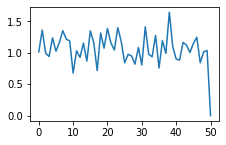

In [62]:
from scipy import integrate

lambda_stat = mega_traj[["lam","dhdlam"]]

means_cvb = np.nan_to_num([np.mean(lambda_stat.loc[np.where(discrete_traj==x+1)].dhdlam) for x in range(nbins+1)])
std_cvb = np.nan_to_num([np.std(lambda_stat.loc[np.where(discrete_traj==x+1)].dhdlam) for x in range(nbins+1)] )

plt.plot(means_cvb)

dF_cvb_trapez = integrate.trapz(x=lam_bins, y=means_cvb)
dF_err = integrate.trapz(x=means_cvb, y=std_cvb)

print()
print("Expected Result: ", dF_expected)
print("trapez Rule Result: ", dF_cvb_trapez, "+-", dF_err)
print()
print("Difference:", dF_cvb_trapez - dF_expected)





### RE-EDS

[0, 0]
DO trials:  100 steps:  100
[1.0, 0.7742636826811271, 0.599484250318941, 0.4641588833612779, 0.35938136638046275, 0.2782559402207124, 0.2154434690031884, 0.1668100537200059, 0.1291549665014884, 0.1]


Text(0.5, 1.0, 'Sampled Potentials')

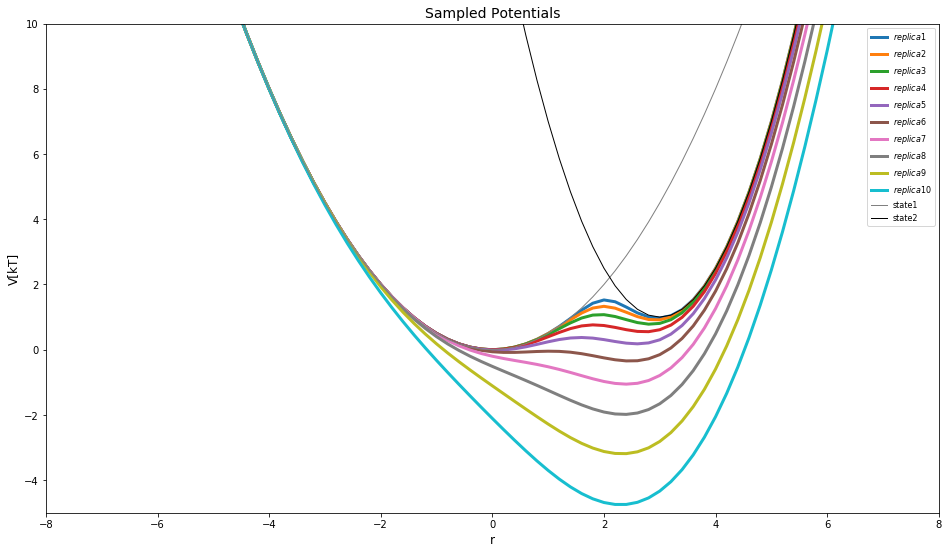

In [105]:
#potential
Eoff = [0,1]
V_eds = pot.envelopedPotential(V_is=[h1,h2])


##System
eds_system = edsSystem(sampler=sampler, potential=V_eds, start_position=4, temperature=temperature)
eds_system.Eoff = Eoff
print(eds_system.potential.Eoff)

##Ensemble
from ensembler.ensemble import replica_exchange
##Ensemble Settings:
s_values = np.logspace(start=0, stop=-1, num=10)
trials=simulation_steps_total_per_approach//100
steps_between_trials=simulation_steps_total_per_approach//trials

print("DO trials: ", trials, "steps: ", steps_between_trials)
ensemble = replica_exchange.replicaExchangeEnvelopingDistributionSampling(system=eds_system, exchange_criterium=None,
                                                                          s_range=s_values, steps_between_trials=steps_between_trials)
print([replica.s for repID, replica in ensemble.replicas.items()])

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

#Visualize
positions = np.arange(-10,10, 0.2)
fig = plt.figure(figsize=[16,9])

for ind,replica in ensemble.replicas.items():
    plt.plot(positions,replica.potential.ene(positions), lw=3, label="$replica "+str(ind+1)+"$")

plt.plot(positions,h1.ene(positions), label="state1", lw=1, color="grey")
plt.plot(positions,h2.ene(positions), label="state2", lw=1, color="black")


plt.legend()  
plt.ylim([-5,10])
plt.xlim([-8,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")


In [106]:
ensemble.simulate(trials, reset_ensemble=True)
reeds_trajs = ensemble.replica_trajectories


Running trials: 100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


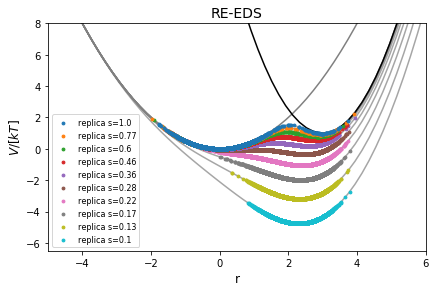

In [107]:

positions = np.linspace(-10,10)
fig, ax = plt.subplots(ncols=1, figsize=style.figsize_doubleColumn)
eqil=100
keys = sorted(list(reeds_trajs.keys()), reverse=False)
              
positions = np.linspace(-10,10, 100)
h1_ene = h1.ene(positions)
h2_ene = h2.ene(positions)

ax.plot(positions, h1_ene, c="grey", zorder=-10,)
ax.plot(positions, h2_ene, c="black", zorder=-10)

for traj in keys:
    s =  round(ensemble.replicas[traj].s,2)
    ax.plot(positions, ensemble.replicas[traj].potential.ene(positions), c="grey", alpha=0.7, zorder=-60)
    min_e = np.min(reeds_trajs[traj].total_potential_energy[eqil:])
    ax.scatter(reeds_trajs[traj].position[eqil:], reeds_trajs[traj].total_potential_energy[eqil:], zorder=-traj, c="C"+str(traj),s=8, label="replica s="+str(s))

ax.set_ylim([-6.5,8])
ax.set_xlim([-5,6])
ax.set_xlabel("r")
ax.set_ylabel("$V/[kT]$")
ax.legend()
ax.set_title("RE-EDS")
fig.savefig("REEDS.pdf")

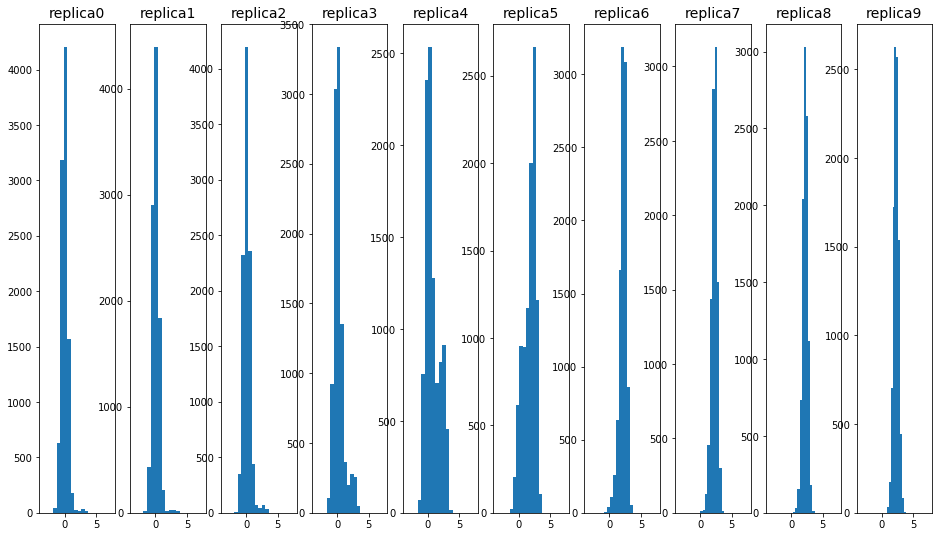

In [108]:
trajs = ensemble.get_trajectories()

positions = np.linspace(-10,10)
fig, axes = plt.subplots(ncols=len(trajs), figsize=[16,9])
eqil=100
for traj, ax in zip(reeds_trajs, axes):
    ax.hist(reeds_trajs[traj].position[eqil:])
    ax.set_xlim([-4,8])
    ax.set_title("replica"+str(traj))


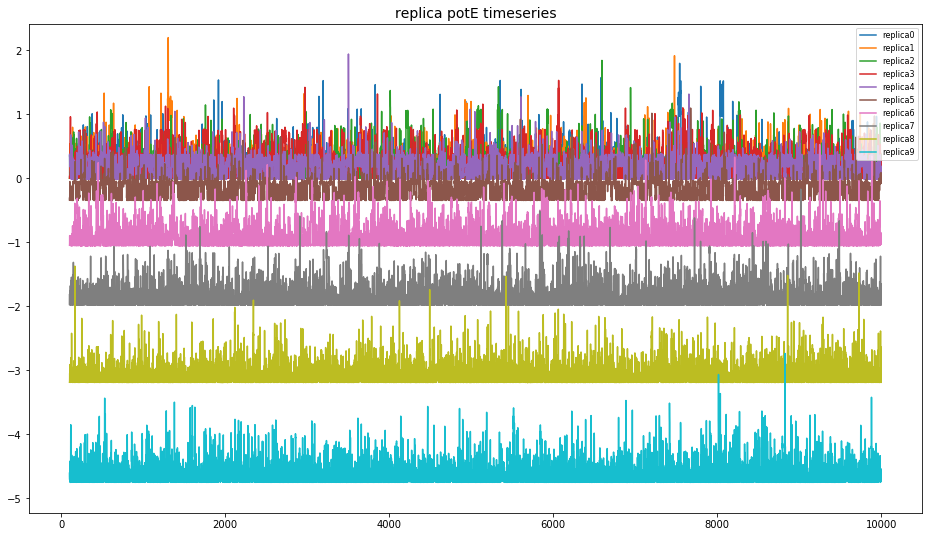

In [109]:

fig, ax = plt.subplots(ncols=1, figsize=[16,9])
enes = [reeds_trajs[x].total_potential_energy[100:] for x in sorted(trajs)] 
min_e = np.min(enes)
max_e = np.max(enes)

for ind, ene in enumerate(enes):
    ax.plot(ene, label="replica"+str(ind))
    
#ax.vlines([steps_between_trials*x for x in range(trials)], ymin=min_e, ymax=max_e, label="exchange", lw=0.1)
ax.set_title("replica potE timeseries")
ax.set_ylim(1.1*min_e, 1.1*max_e)
ax.legend()

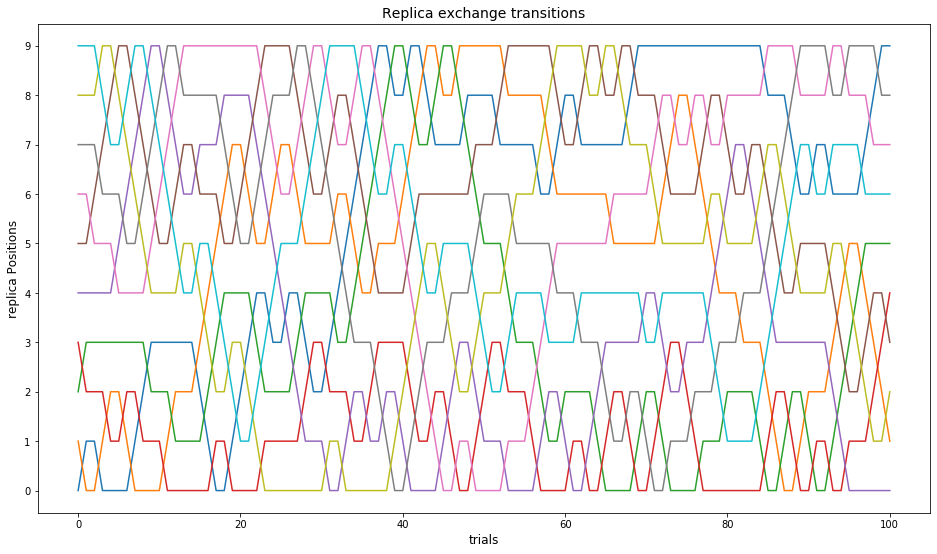

In [110]:
stats= ensemble.exchange_information
replicas = np.unique(ensemble.exchange_information.replicaID)
trials = np.unique(ensemble.exchange_information.nExchange)

import itertools as it

fig, ax = plt.subplots(ncols=1, figsize=[16,9])

replica_positions = {}
for replica in replicas:
    replica_positions.update({replica: stats.loc[stats.replicaID==replica].replicaPositionI})

    x = trials
    y = replica_positions[replica]

    ax.plot(x,y , label="replica_"+str(replica))

#plt.yticks(replicas+1, reversed(replicas+1))
ax.set_yticks(ticks=replicas)
ax.set_yticklabels(labels=replicas)

ax.set_ylabel("replica Positions")
ax.set_xlabel("trials")
ax.set_title("Replica exchange transitions")
if(len(replicas)<10): plt.legend()

In [111]:
rew_zwanz = threeStateZwanzigReweighting(kT=True)
zwanz = zwanzigEquation(kT=True)
equilibration_steps=10
#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

dFresults = []
s_vals = []
for ind,key in enumerate(reeds_trajs):
    s_vals.append(reeds_trajs[key].s[1])
    traj_positions = reeds_trajs[key].position[equilibration_steps:]
    Vr = reeds_trajs[key].total_potential_energy[equilibration_steps:]
    V1 = h1.ene(traj_positions)
    V2 = h2.ene(traj_positions)

    dFRew_zwanz = rew_zwanz.calculate(Vi=V1, Vj=V2, Vr=Vr)
    dFresults.append(dFRew_zwanz)

print()
print("\tExpected Result: ", dF_expected)
print("s\t\tdF\t\tdiff")
print("\n".join(map(str, ["\t\t".join(map(str, np.round(x,5))) for x in  zip(s_vals, dFresults, dFresults - dF_expected)])))
print("\n\n\n")


	Expected Result:  1.2746530721670273
s		dF		diff
1.0		5.02539		3.75074
0.77426		4.97154		3.69688
0.59948		4.50213		3.22748
0.46416		3.27181		1.99716
0.35938		2.40139		1.12674
0.27826		1.07978		-0.19487
0.21544		0.13533		-1.13932
0.16681		-0.22071		-1.49537
0.12915		-0.3965		-1.67115
0.1		-0.38358		-1.65823






## Final Results

In [66]:
md_str = "| method | dF  | deviation |\n"
md_str += "|---|---|---|\n"
md_str += "| analytical   | "+str(np.round(dF_expected,2))+"  |   | \n"
md_str += "| Zwanzig   | "+str(np.round(dF_zwanzig,2))+"  | "+str(np.round(dF_zwanzig-dF_expected,2))+" | \n"
md_str += "| BAR   | "+str(np.round(dF_bar,2))+"  | "+str(np.round(dF_bar-dF_expected,2))+" | \n"

md_str += "| FEP 10-$\lambda$ Points   | "+str(np.round(dF_FEP_10lambda,2))+"  | "+str(np.round(dF_FEP_10lambda-dF_expected,2))+" | \n"
md_str += "| TI 10-$\lambda$ Points  | "+str(np.round(dF_trapez,2))+"  | "+str(np.round(dF_trapez-dF_expected,2))+" | \n"

md_str += "| EDS   | "+str(np.round(dF_EDS,2))+"  | "+str(np.round(dF_EDS-dF_expected,2))+" | \n"
md_str += "| EDS-BAR   | "+str(np.round(dF_EDS_bar,2))+"  | "+str(np.round(dF_EDS_bar-dF_expected,2))+" | \n"
md_str += "| $\lambda$ EDS   | "+str(np.round(dF_leds,2))+"  | "+str(np.round(dF_leds-dF_expected,2))+" | \n"

md_str += "| conveyor belt TI   | "+str(np.round(dF_cvb_trapez,2))+"  | "+str(np.round(dF_cvb_trapez-dF_expected,2))+" | \n"
#md_str += "| RE-DS   | "+str(np.round(dFresults[0],2))+"  | "+str(np.round(dFresults[0]-dF_expected,2))+" | \n"


from IPython.display import display, Markdown, Latex
display(Markdown(md_str))


| method | dF  | deviation |
|---|---|---|
| analytical   | 1.27  |   | 
| Zwanzig   | 8.39  | 7.11 | 
| BAR   | 2.83  | 1.56 | 
| FEP 10-$\lambda$ Points   | 1.0  | -0.27 | 
| TI 10-$\lambda$ Points  | 1.21  | -0.06 | 
| EDS   | 1.54  | 0.27 | 
| EDS-BAR   | 1.18  | -0.09 | 
| $\lambda$ EDS   | 1.6  | 0.33 | 
| conveyor belt TI   | 1.07  | -0.2 | 
| RE-DS   | 5.05  | 3.78 | 
